<a href="https://colab.research.google.com/github/DimpleB0501/Assignment_cifar10_resnet/blob/main/backup/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment
Write a custom ResNet architecture for CIFAR10.

-   Atleast two resnet blocks

-   Initial conv block and final fully connected/Global avg pooling layer plus  any number of downscale/conv layers you might want to include

-          3x3 convolutions

-          <5 million params


Use One Cycle Learning rate Policy and determine max learning rate to use.

Uses this transform -RandomCrop 32, 32 (after padding of 4),  FlipLR, Followed by CutOut(8, 8)

Target test accuracy 90% within 25 epochs

Nice to have: use gradcam to find heatmaps for 10 incorrect labelled images.

Share code for augmentation, model definition, learning rate determination, and train/test logs.


In [ ]:
!pip3 install numpy
!pip3 install torch torchvision
!pip3 install matplotlib

# Import package

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F



import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.10.0+cu111


# GPU mode

In [ ]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("No GPU available")

On GPU


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading CIFAR-10 dataset

In [ ]:
batch_size = 50

### Transform
- RandomCrop 32, 32 (after padding of 4)
- FlipLR using RandomHorizontalFlip() instead
- Followed by CutOut(8, 8)



In [ ]:
class Cutout(object): # based on github code on Code
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes=8, length=8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Transforms
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     normalize])

#train_transform.transforms.append(Cutout(8, 2))

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    normalize])

# CIFAR-10 dataset

In [ ]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Plot training images

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def show_batch(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print ("Image shape: ", images[0].shape) # use to determine the number of parameters for the model

Image shape:  torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                  plane                    bird                    ship                     dog                    deer


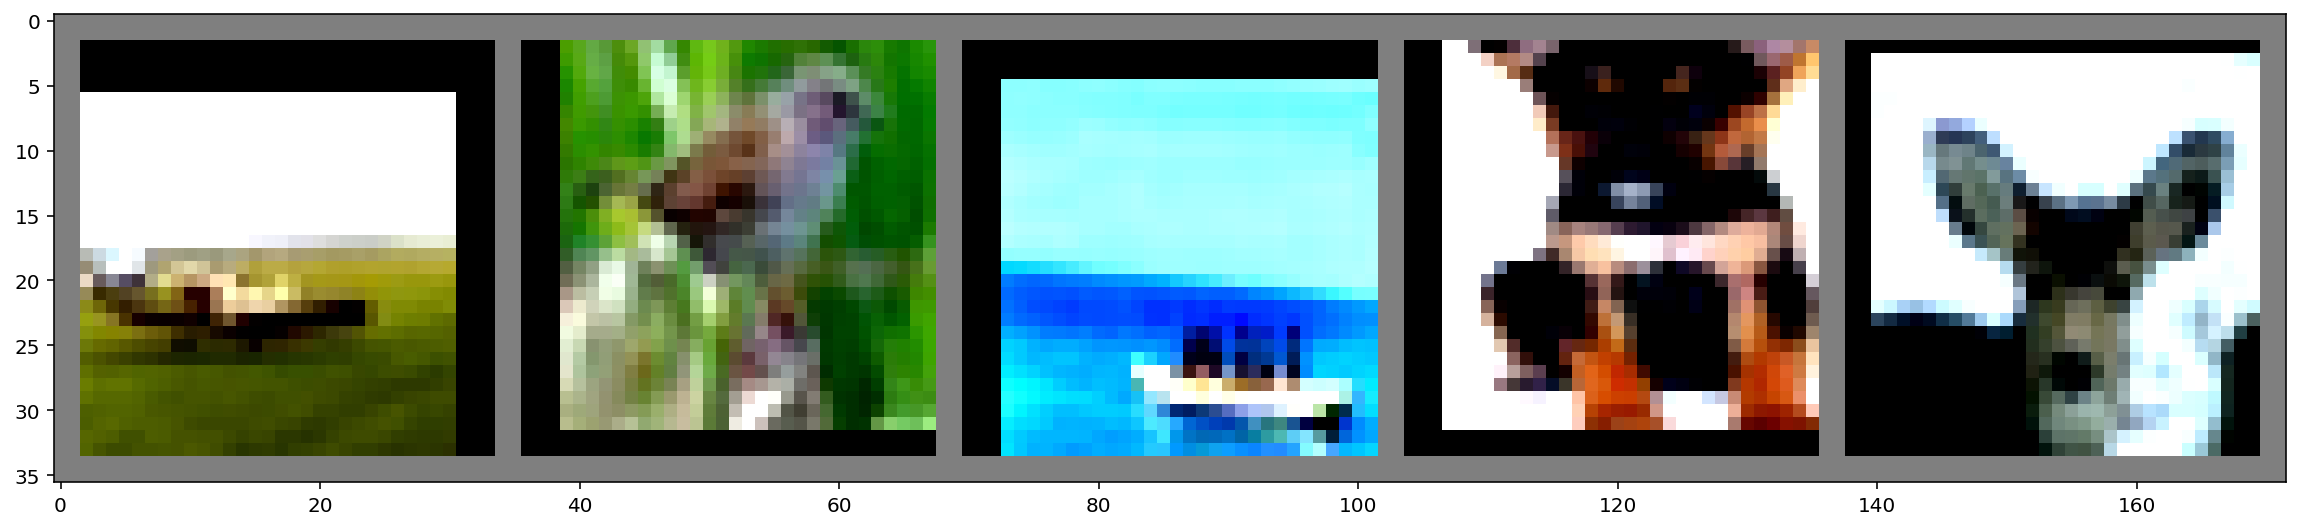

In [ ]:
plt.figure(figsize = (20, 20))

# show images
show_batch(torchvision.utils.make_grid(images[0:5,:,:]))
# print labels
print(' '.join('%23s' % classes[labels[j]] for j in range(5)))

# ResNet50 architecture implementation

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [ ]:
from functools import reduce
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

In [ ]:
from torchsummary import summary

net = ResNet18().to(device)
print(pytorch_count_params(net))

#summary(net, (3,32,32))

11173962


# Train


In [ ]:
# Hyper-parameters
num_epochs = 25
learning_rate = 0.001

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(trainloader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


Epoch [1/25], Step [100/1000] Loss: 1.7428
Epoch [1/25], Step [200/1000] Loss: 1.8580
Epoch [1/25], Step [300/1000] Loss: 1.4838
Epoch [1/25], Step [400/1000] Loss: 1.3919
Epoch [1/25], Step [500/1000] Loss: 1.3149
Epoch [1/25], Step [600/1000] Loss: 1.4078
Epoch [1/25], Step [700/1000] Loss: 1.3540
Epoch [1/25], Step [800/1000] Loss: 1.3164
Epoch [1/25], Step [900/1000] Loss: 1.0012
Epoch [1/25], Step [1000/1000] Loss: 1.3028
Epoch [2/25], Step [100/1000] Loss: 1.0809
Epoch [2/25], Step [200/1000] Loss: 1.0210
Epoch [2/25], Step [300/1000] Loss: 1.0014
Epoch [2/25], Step [400/1000] Loss: 1.0152
Epoch [2/25], Step [500/1000] Loss: 1.3168
Epoch [2/25], Step [600/1000] Loss: 1.0158
Epoch [2/25], Step [700/1000] Loss: 1.1772
Epoch [2/25], Step [800/1000] Loss: 1.2444
Epoch [2/25], Step [900/1000] Loss: 0.9820
Epoch [2/25], Step [1000/1000] Loss: 1.1247
Epoch [3/25], Step [100/1000] Loss: 0.7301
Epoch [3/25], Step [200/1000] Loss: 0.8158
Epoch [3/25], Step [300/1000] Loss: 0.5955
Epoch [3/

# Test

In [ ]:
# Test the model
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
# Save the model checkpoint
torch.save(net.state_dict(), 'resnet.ckpt')

Accuracy of the model on the test images: 92.0 %


# Validate


In [ ]:
# Function to test the model with a batch of images and show the labels predictions

end_val = 10

def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testloader))

    # show all images as one image grid
    show_batch(torchvision.utils.make_grid(images[:end_val]))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(end_val)))
  
    predicted_vals=[]
    for r in range(end_val):
      image_in = images[r].unsqueeze(0).to(device)
      # Let's see what if the model identifiers the  labels of those example
      outputs = net(image_in)        
    
      # We got the probability for every 10 labels. The highest (max) probability should be correct label
      _, predicted = torch.max(outputs, 1)
      predicted_vals.append(classes[predicted])
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % predicted_vals))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real labels:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:  [ ' c a t ' ,   ' s h i p ' ,   ' s h i p ' ,   ' p l a n e ' ,   ' f r o g ' ,   ' f r o g ' ,   ' c a r ' ,   ' f r o g ' ,   ' c a t ' ,   ' c a r ' ]


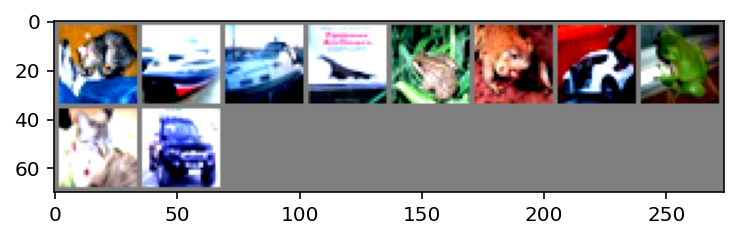

In [ ]:
testBatch()

#Implementing gradcam

Using following github code as [reference](https://github.com/jacobgil/pytorch-grad-cam/blob/master/cam.py) 

In [ ]:
!pip3 install grad-cam



     |████████████████████████████████| 4.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=4fc5e8857df0dfec226d27c660623e6478a817593645d771812e0080f1a9f298
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


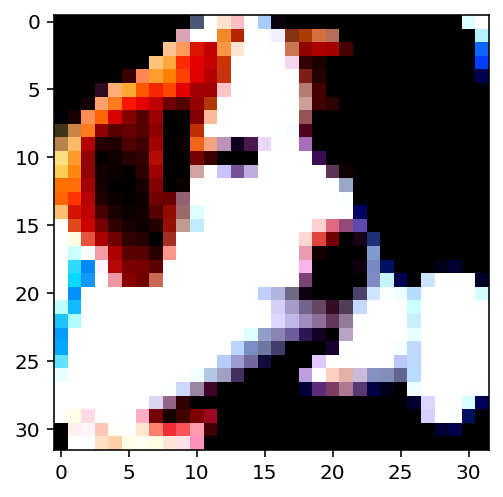

In [ ]:
img, _ = next(iter(testloader))
img_tensor = img[16].unsqueeze(0).to(device)
img=img[16].permute(1, 2, 0) 
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


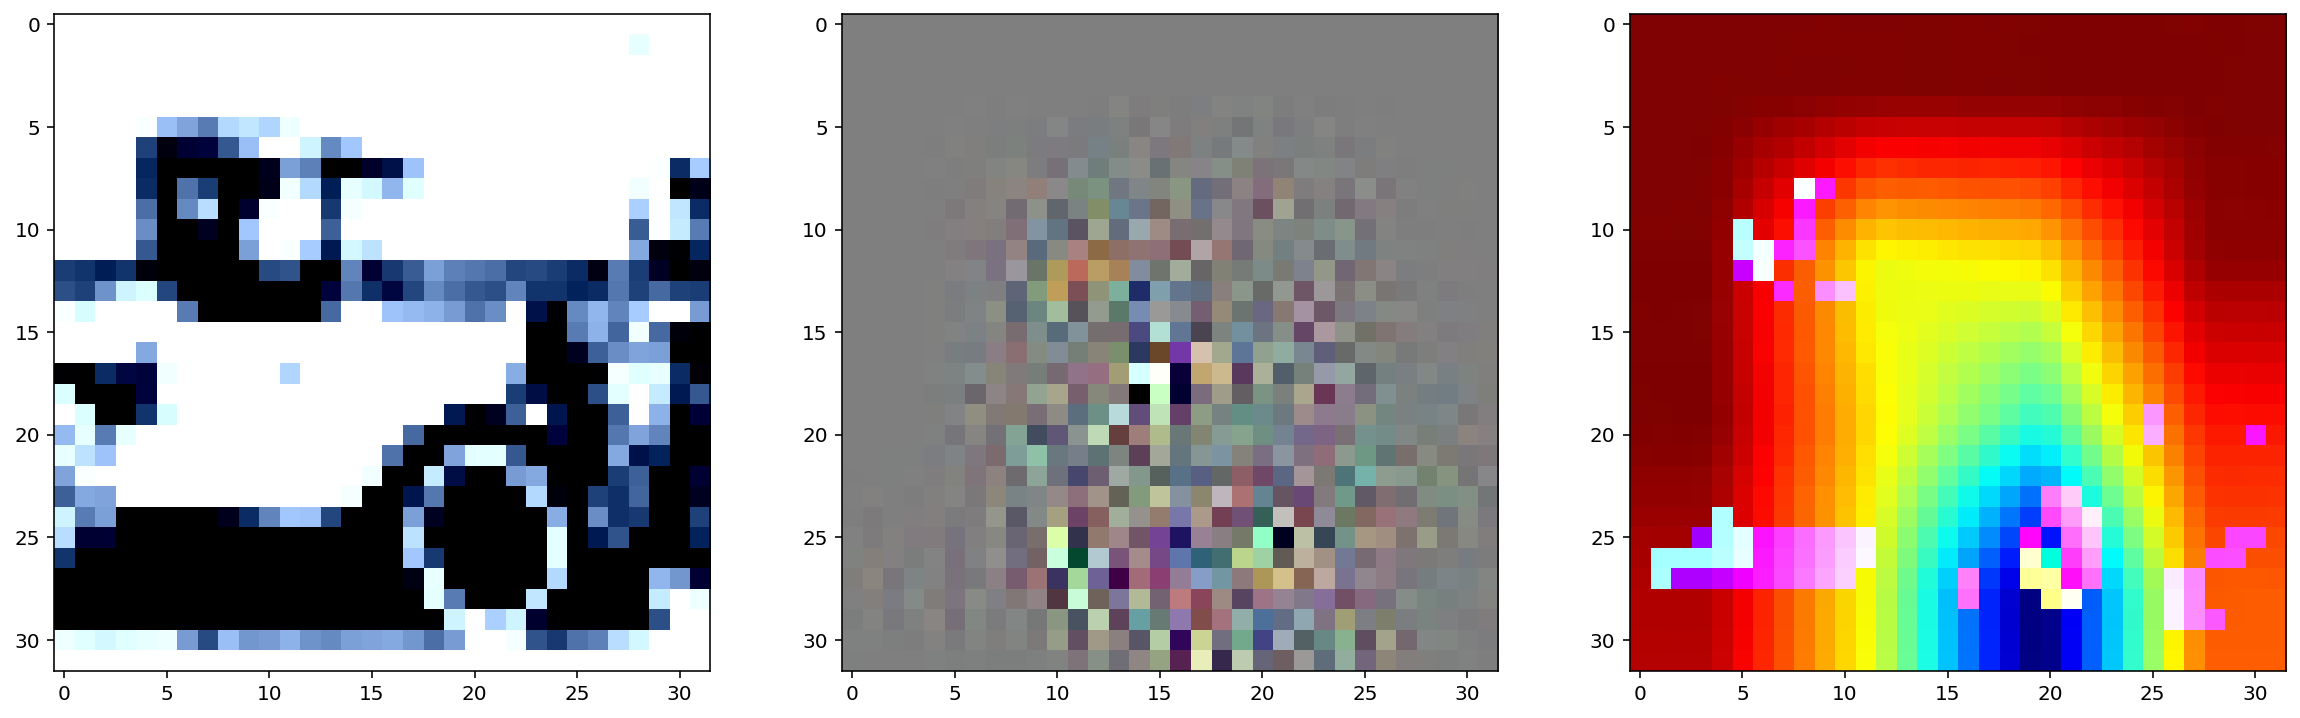

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
import cv2
import random

image_id = random.randint(1,50)
#print (image_id)

plt.figure(figsize = (20, 20))

img, _ = next(iter(testloader))
img_tensor = img[image_id].unsqueeze(0).to(device)
img=img[image_id].permute(1, 2, 0) 

plt.subplot(1, 3, 1)
plt.imshow(img)

cam = GradCAM(model=net, target_layers=net.layer4)

target_category = None

grayscale_cam = cam(input_tensor=img_tensor)

grayscale_cam = grayscale_cam[0, :]
#print (grayscale_cam, len(grayscale_cam))
#print (img, len(img))

gb_model = GuidedBackpropReLUModel(model=net, use_cuda=True)
gb = gb_model(img_tensor, target_category=None)
cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)

rgb_img = np.float32(img) / 255

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
plt.subplot(1, 3, 2)
plt.imshow(cam_gb)

plt.subplot(1, 3, 3)
plt.imshow(cam_image)